# Microsatellite Instability (MSI) Analysis Pipeline.

**Context:**

Microsatellite instability (MSI) arises from defects in the DNA mismatch repair system and is observed in multiple cancer types, where it serves as an important molecular biomarker with diagnostic, prognostic, and therapeutic relevance, particularly in the context of immunotherapy response.

Computational assessment of MSI can be performed using distributions of short tandem repeat (STR) lengths derived from sequencing data. While microsatellite-stable (MSS) samples show narrow and consistent STR distributions, MSI samples exhibit increased variability.

The proposed pipeline employs an entropy-based metric to quantify repeat instability at the level of individual STR loci and supports both single-sample and batch classification. To address variability and outliers in reference data, instability scores are converted into probabilistic estimates.


**Dataset:**

Due to ethical and data protection considerations, the original sequencing data cannot be made publicly available. So, in this project, STR1, STR2, … are used as abstract identifiers of microsatellite loci.

This repository provides an example dataset (**“example_STRs_MSS_MSI.xlsx”**) that reproduces the structure and format of the original data and can be used to demonstrate and validate the analysis pipeline.


**Input Data Format:**

Rows: STR repeat lengths (e.g. 9(A), 10(A), 11(A)),
Columns: sequencing samples,
Values: fraction of reads corresponding to each STR length.

The dataset should include reference samples without microsatellite instability (MSS) for model calibration and tumor samples to be classified (MSI candidates).


**Objective:**

To develop a pipeline for determining microsatellite instability in a patient’s tumor based on sequencing data.


**Tasks:**

**№1**. Create a metric for classifying samples (“stable” / “unstable”).

**№2**. Write a script to determine the stability status of an experimental sample using MSS reference data for a specific STR. Estimate the probability of instability.

**№3**. Apply the script to all MSI samples and compile the results into a new table.



# Imports

In [1]:
pip install adjustText

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from scipy.stats import entropy
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

The analysis is conducted in Google Colab, with Google Drive mounted for data access and result storage.

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Specify the <font color='red'>path to the working directory</font> where the analysis will be performed.

In [4]:
PATH='/content/drive/MyDrive/MSI_project'

# Task 1. Creating a Metric for Classifying Samples (“Stable” / “Unstable”).

We load the table and reshape it into a format convenient for downstream analysis.



In [5]:
STRs = pd.read_excel(f'{PATH}/example_STRs_MSS_MSI.xlsx', engine='openpyxl')

In [6]:
str_value = None
for index, row in STRs.iterrows():
    found = None
    for val in row:
        if type(val) == str and 'STR' in val:
            found = val
            break
    if found:
        str_value = found
    if str_value:
        STRs.loc[index] = STRs.loc[index].fillna(str_value)
STRs.head(50)

,Samples ->,MSI-1,MSI-2,MSI-3,MSI-4,MSI-5,MSI-6,MSI-7,MSI-8,MSI-9,...,MSS-7,MSS-8,MSS-9,MSS-10,MSS-11,MSS-12,MSS-13,MSS-14,MSS-15,MSS-16
0,STR1,STR1,STR1,STR1,STR1,STR1,STR1,STR1,STR1,STR1,...,STR1,STR1,STR1,STR1,STR1,STR1,STR1,STR1,STR1,STR1
1,9(A),0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10(A),0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11(A),0.000409,0.0,0.0,0.0,0.0,0.000151,0.0,0.000133,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12(A),0.003678,0.000312,0.000439,0.0,0.0,0.000378,0.000253,0.003323,0.000464,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,13(A),0.03192,0.001918,0.002489,0.000095,0.000238,0.002682,0.004179,0.026519,0.003516,...,0.0,0.0,0.0,0.0,0.000656,0.0,0.0,0.0,0.0,0.0
6,14(A),0.135262,0.010881,0.013762,0.000851,0.002302,0.017678,0.025412,0.101422,0.020944,...,0.0,0.003636,0.00349,0.002375,0.0,0.0,0.0,0.00163,0.002336,0.0
7,15(A),0.082864,0.047982,0.07031,0.003546,0.011232,0.093828,0.08358,0.100259,0.055334,...,0.002611,0.007273,0.001994,0.002375,0.002295,0.004216,0.002424,0.002445,0.001168,0.006446
8,16(A),0.063249,0.099933,0.172242,0.014893,0.046515,0.222407,0.116378,0.072478,0.037637,...,0.015666,0.003636,0.017448,0.017815,0.01541,0.013032,0.015758,0.00652,0.018692,0.026591
9,17(A),0.095532,0.15126,0.200791,0.063496,0.149349,0.159968,0.111862,0.099196,0.061826,...,0.031332,0.056364,0.052841,0.062945,0.069836,0.045611,0.046061,0.041565,0.091121,0.132957


In [7]:
STRs = STRs.set_index(STRs.columns[0])

To work with individual STRs (STR1, STR2, STR3), we split the original STRs dataframe into separate dataframes and store them in a dictionary for convenient iteration later on.

In [24]:
block_size = 21
num_blocks = 3
STR_dfs_dict = {}
for i in range(num_blocks):
  start = i * block_size
  end = start + block_size
  STR_name = f'STR{i+1}_df'
  STR_dfs_dict[STR_name] = STRs.iloc[start:end].reset_index(drop=True)

Exact repeat lengths are not critical; instead, we focus on the distribution of read fractions, as microsatellite lengths can vary between individuals and between the two alleles of the same individual.

In [25]:
for key in STR_dfs_dict:
  STR_dfs_dict[key] = STR_dfs_dict[key].iloc[1:].reset_index(drop=True)
  STR_dfs_dict[key] = STR_dfs_dict[key].apply(pd.to_numeric, errors='coerce')
  globals()[key] = STR_dfs_dict[key]

In [26]:
samples_order = list(STR1_df.columns)

Let’s take a look at the data using STR1 as an example.

In [27]:
STR1_df

,MSI-1,MSI-2,MSI-3,MSI-4,MSI-5,MSI-6,MSI-7,MSI-8,MSI-9,MSI-10,...,MSS-7,MSS-8,MSS-9,MSS-10,MSS-11,MSS-12,MSS-13,MSS-14,MSS-15,MSS-16
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000409,0.000000,0.000000,0.000000,0.000000,0.000151,0.000000,0.000133,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.003678,0.000312,0.000439,0.000000,0.000000,0.000378,0.000253,0.003323,0.000464,0.000197,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.031920,0.001918,0.002489,0.000095,0.000238,0.002682,0.004179,0.026519,0.003516,0.002789,...,0.000000,0.000000,0.000000,0.000000,0.000656,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.135262,0.010881,0.013762,0.000851,0.002302,0.017678,0.025412,0.101422,0.020944,0.019654,...,0.000000,0.003636,0.003490,0.002375,0.000000,0.000000,0.000000,0.001630,0.002336,0.000000
6,0.082864,0.047982,0.070310,0.003546,0.011232,0.093828,0.083580,0.100259,0.055334,0.102730,...,0.002611,0.007273,0.001994,0.002375,0.002295,0.004216,0.002424,0.002445,0.001168,0.006446
7,0.063249,0.099933,0.172242,0.014893,0.046515,0.222407,0.116378,0.072478,0.037637,0.223276,...,0.015666,0.003636,0.017448,0.017815,0.015410,0.013032,0.015758,0.006520,0.018692,0.026591
8,0.095532,0.151260,0.200791,0.063496,0.149349,0.159968,0.111862,0.099196,0.061826,0.161001,...,0.031332,0.056364,0.052841,0.062945,0.069836,0.045611,0.046061,0.041565,0.091121,0.132957
9,0.134308,0.167715,0.132128,0.205711,0.288022,0.118531,0.153820,0.049714,0.179914,0.086456,...,0.126632,0.225455,0.216849,0.180523,0.190820,0.198927,0.220606,0.118174,0.214953,0.298147


We introduce a metric that most accurately captures repeat instability within a sample.

**Entropy, as a measure of distribution complexity, is well suited for this task.**
The threshold is chosen as the 0.95 percentile of entropy values calculated for MSS samples.
In this case, the percentile-based approach appears optimal, as it does not impose assumptions on the underlying distribution.



In [28]:
def simple_entropy(col):
    p = col + 1e-9
    p = p / p.sum()
    return entropy(p)

In [29]:
def entropy_class(df):
    df_MSS = df.loc[:, df.columns.str.contains('MSS')]
    df_MSI = df.loc[:, df.columns.str.contains('MSI')]
    entropies = df.apply(simple_entropy, axis=0)
    entropies_MSS = df_MSS.apply(simple_entropy, axis=0)
    threshold_entropy = entropies_MSS.quantile(0.95)
    classes_entropy = entropies.apply(lambda x: 'stable' if x < threshold_entropy else 'unstable')
    df_entropy = classes_entropy.to_frame(name='class_entropy')
    return df_entropy

We classify samples based on entropy and visualize the results using PCA for STR1.

       class_entropy
MSI-1       unstable
MSI-2       unstable
MSI-3       unstable
MSI-4         stable
MSI-5         stable
MSI-6       unstable
MSI-7       unstable
MSI-8       unstable
MSI-9       unstable
MSI-10      unstable
MSI-11        stable
MSI-12      unstable


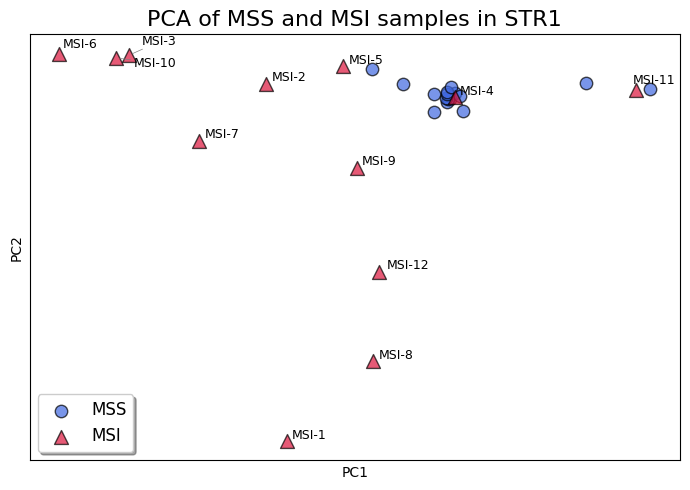

In [30]:
STR1_entropy_class = entropy_class(STR1_df).head(12)
print(STR1_entropy_class)

STR1_df_MSI = STR1_df.loc[:, STR1_df.columns.str.contains('MSI')]
STR1_df_MSS = STR1_df.loc[:, STR1_df.columns.str.contains('MSS')]
X_train = STR1_df_MSS.T.values
X_test = STR1_df_MSI.T.values
test_samples = STR1_df_MSI.columns.tolist()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(7, 5))

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c='royalblue', label='MSS',
            alpha=0.7, s=80, edgecolors='black', marker='o')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c='crimson', label='MSI',
            alpha=0.7, s=100, edgecolors='black', marker='^')

texts = []
for i, label in enumerate(test_samples):
    texts.append(plt.text(X_test_pca[i, 0] + 0.03, X_test_pca[i, 1] + 0.03,
                          label, fontsize=9, color='black'))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.title('PCA of MSS and MSI samples in STR1', fontsize=16)
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks([])
plt.yticks([])

plt.xlabel(f'PC1')
plt.ylabel(f'PC2')

plt.tight_layout()
plt.show()


The PCA visualization is consistent with the entropy-based classification: MSI-4, MSI-5, and MSI-11 samples for STR1 are classified as “stable” based on entropy, while the remaining MSI samples are classified as “unstable”.

It seems that MSS samples contain outliers; this issue will be handled in subsequent steps by applying a probability threshold.



# Task 2. Pipeline for Experimental Sample Classification.

We develop a pipeline for classifying the stability of a sample based on an input vector (where the vector corresponds to a single row of the original table for an experimental sample) and an MSS reference table for a specific STR.

As an example, we work with STR1: we take the MSI-1 sample as the input vector and use the STR1 MSS samples as the reference. For that, these data are saved to a directory and used as inputs for the pipeline.

In [31]:
STR1_df_MSS.to_csv(f'{PATH}/STR1_df_MSS.tsv', sep='\t')
STR1_df_MSI.to_csv(f'{PATH}/STR1_df_MSI.tsv', sep='\t')
STR1_vector=STR1_df_MSI.iloc[:,:1].to_numpy()
np.save(f'{PATH}/STR1_vector.npy', STR1_vector)

Specify your <font color='red'> __ paths to the table (tsv) and the vector (npy)__</font>; example STR1 data are used by default.

In [32]:
example_tsv_path=f'{PATH}/STR1_df_MSS.tsv'
example_input_vector_path = f'{PATH}/STR1_vector.npy'

Below are two functions that:

*  compute entropy values for each column in the MSS input table and determine the threshold (95th percentile);
*  compute the entropy of the input vector;
*  transform the difference between the input vector entropy and the threshold into a probability in the range[0,1] using a sigmoid function;
*  apply a probability threshold (set to 0.6), above which a sample is classified as unstable.







In [33]:
def probability_entropy(entropy, threshold, scale=5):
    return 1 / (1 + np.exp(-scale * (entropy - threshold)))
def vector_entropy_class(tsv_table, input_vector):
    entropies_MSS = df_MSS.apply(simple_entropy, axis=0)
    threshold = entropies_MSS.quantile(0.95)
    input_entropy = simple_entropy(input_vector)
    proba = probability_entropy(input_entropy, threshold)
    if proba >= 0.6:
      label = "Unstable"
    else:
       label = "Stable"
    instability_probability=round(float(proba[0]), 2)
    return label, instability_probability

In [34]:
df_MSS=pd.read_csv(f'{example_tsv_path}', sep='\t', index_col=0)
example_input_vector=np.load(f'{example_input_vector_path}')

We implement the functions using MSI-1 from the STR1 table as an example.

In [35]:
label, proba = vector_entropy_class(df_MSS, example_input_vector)
print(f"Output: {label} (probability {proba})")

Output: Unstable (probability 0.95)


# Task 3. Pipeline for Entire DataFrame Classification.

We create a function to classify all MSI samples by analogy with the classification of a single input vector.

To do this, we iterate over the dictionary of dataframes STR_dfs_dict obtained in Task 1. The results are stored in new dataframes and collected in the dictionary STRs_class_plus_proba.


In [36]:
STRs_class_plus_proba = {}

for df_key, df_values in STR_dfs_dict.items():
    df_MSS = df_values.loc[:, df_values.columns.str.contains('MSS')]
    df_MSI = df_values.loc[:, df_values.columns.str.contains('MSI')]
    MSS_entropies = df_MSS.apply(simple_entropy, axis=0)
    threshold = MSS_entropies.quantile(0.95)
    entropy_results = []
    for i in range(df_values.shape[1]):
        input_vector = df_values.iloc[:, i].to_numpy()
        input_entropy = simple_entropy(input_vector)
        proba = round(probability_entropy(input_entropy, threshold), 3)
        if proba >= 0.6:
          label = "Unstable"
        else:
          label = "Stable"
        entropy_results.append({
            'sample': df_values.columns[i],
            'class': label,
            'instability_probability': proba
        })

    proba_df = pd.DataFrame(entropy_results)
    STRs_class_plus_proba[df_key] = proba_df

We merge all dataframes.

In [37]:
def merged_table(dfs_dict):
    df_merged = None
    for df_key, df_value in dfs_dict.items():
        df_renamed = df_value.rename(columns={
            'class': f'{df_key}_class',
            'instability_probability': f'{df_key}_instability_probability'
        })
        df_renamed = df_renamed.set_index('sample')

        if df_merged is None:
            df_merged = df_renamed
        else:
            df_merged = df_merged.join(df_renamed, how='outer')
    df_merged = df_merged.loc[samples_order]

    return df_merged.reset_index()

Let us examine the final dataframe and save it. In this table, samples are represented in rows, while STR identifiers are represented in columns.

In [38]:
Stability_final_table = merged_table(STRs_class_plus_proba)
Stability_final_table.columns = Stability_final_table.columns.str.replace('df_', '', regex=False)
Stability_final_table.set_index('sample', inplace=True)
Stability_final_table = Stability_final_table.loc[Stability_final_table.index.str.contains('MSI')]
Stability_final_table

,STR1_class,STR1_instability_probability,STR2_class,STR2_instability_probability,STR3_class,STR3_instability_probability
sample,,,,,,
MSI-1,Unstable,0.951,Stable,0.148,Unstable,0.826
MSI-2,Unstable,0.770,Unstable,0.679,Unstable,0.780
MSI-3,Unstable,0.789,Stable,0.318,Unstable,0.919
MSI-4,Stable,0.288,Stable,0.241,Stable,0.531
MSI-5,Stable,0.500,Stable,0.109,Unstable,0.776
MSI-6,Unstable,0.813,Stable,0.390,Unstable,0.950
MSI-7,Unstable,0.817,Unstable,0.646,Unstable,0.918
MSI-8,Unstable,0.949,Unstable,0.750,Unstable,0.917
MSI-9,Unstable,0.649,Stable,0.237,Unstable,0.804


In [39]:
Stability_final_table.to_csv(f'{PATH}/Stability_final_table.tsv', sep='\t', index=False)